# i. Introduction

**Name: Fernaldy Aristo Wirjowerdojo**

This programme was created to perform classification on the different jellyfish types:
- Barrel jellyfish
- Compass jellyfish
- Mauve Stinger jellyfish
- Blue jellyfish
- Lions Mane jellyfish
- Moon jellyfish

From the dataset obtained in [Kaggle](https://www.kaggle.com/datasets/anshtanwar/jellyfish-types). The classification is done with a model primarily focusing on the usage of CNN model architecture. The data is first checked for consistency in terms of image size and colour channels before moving on to augmenting the images to generate more training images. Multiple models were created to find the best fit model.

NOTE: This programme was primarily written in `Google Colab`, expect some functions to return an error upon running all.

---

# ii. Import Libraries

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from PIL import Image
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report

from google.colab import drive
import warnings

---

# iii. Data Loading

In [78]:
warnings.filterwarnings('ignore')

In [79]:
drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle/kaggle.json' ~/.kaggle
!kaggle datasets download -d anshtanwar/jellyfish-types

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
jellyfish-types.zip: Skipping, found more recently modified local copy (use --force to force download)


In [80]:
!unzip -q -o /content/jellyfish-types.zip -d /content/jellyfish

In [81]:
!ls /content/jellyfish

barrel_jellyfish  compass_jellyfish	mauve_stinger_jellyfish  Train_Test_Valid
blue_jellyfish	  lions_mane_jellyfish	Moon_jellyfish


In [82]:
jellyfish_path = {
    'Barrel Jellyfish'          : 'barrel_jellyfish',
    'Moon Jellyfish'            : 'Moon_jellyfish',
    'Blue Jellyfish'            : 'blue_jellyfish',
    'Compass Jellyfish'         : 'compass_jellyfish',
    'Lions Mane Jellyfish'      : 'lions_mane_jellyfish',
    'Mauve Stinger Jellyfish'   : 'mauve_stinger_jellyfish'
}
for species, path in jellyfish_path.items():
    class_count = len(os.listdir(os.path.join('/content', 'jellyfish', f'{path}')))
    print(f'There are {class_count} images of the {species} species in the data')

There are 150 images of the Barrel Jellyfish species in the data
There are 150 images of the Moon Jellyfish species in the data
There are 150 images of the Blue Jellyfish species in the data
There are 150 images of the Compass Jellyfish species in the data
There are 150 images of the Lions Mane Jellyfish species in the data
There are 150 images of the Mauve Stinger Jellyfish species in the data


---

# iv. Exploratory Data Analysis

## Examples from each Species

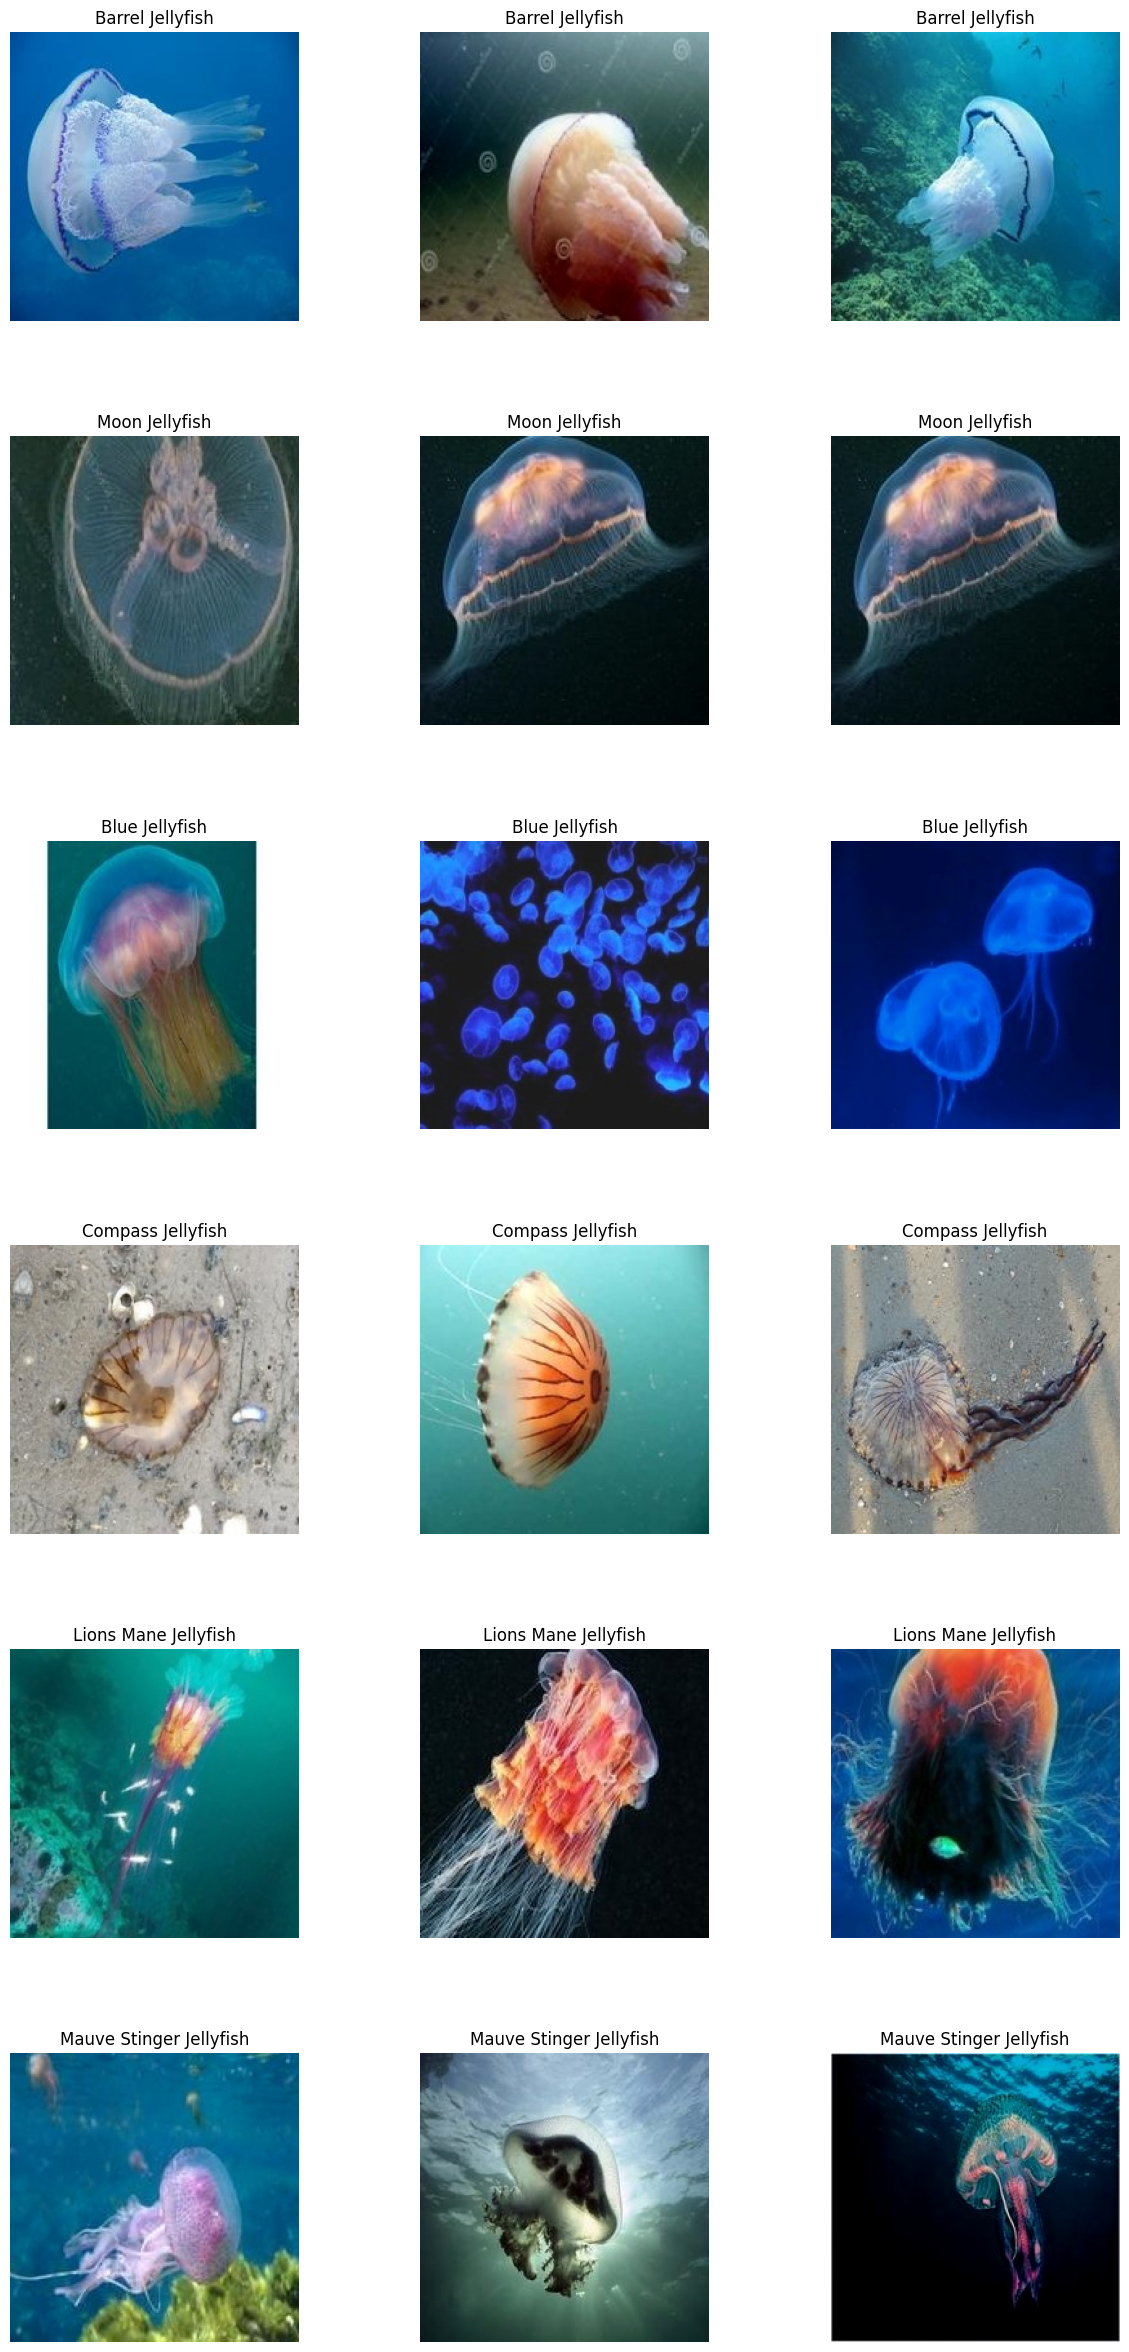

In [83]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 30))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

for i, (species, folder) in enumerate(jellyfish_path.items()):
    image_list = os.listdir(os.path.join('/content', 'jellyfish', f'{folder}')) # File names in the folder
    rand_index = np.random.randint(0, len(image_list), 3)
    selected_images = [image_list[i] for i in rand_index]
    for j, im in enumerate(selected_images):
        image_path = os.path.join('/content', 'jellyfish', f'{folder}', f'{im}') # File path in the folder
        image = Image.open(image_path)
        axes[i, j].imshow(image)
        axes[i, j].set_title(f'{species}')
        axes[i, j].axis('off')

plt.show()

From the images, the jellyfishes each have their own unique characteristics:
- Barrel Jellyfish: Barrel shaped bell and a small portion of their arms near the bell appear to be covered in some membrane
- Moon Jellyfish: Just under the bell of the jellyfish there is a flowery pattern
- Blue Jellyfish: They are blue coloured, appear translucent and have shorter tentacles
- Compass Jellyfish: The bell has a compass pattern
- Lions Mane: Numerous and long tentacles
- Mauve Stinger Jellyfish: Thicker arms and less tentacles

Furthermore, since the data only provides 150 images from each species. The data augmentation technique `ImageDataGenerator` will be used to procure more training data by applying:
- Horizontal / Vertical Flipping
- Image rotations
- Image shearing
- Zooming // Zooming images will be limited as not to create noise for the model

Other data augmentation technique that is a part of `ImageDataGenerator` such as: Cropping, noise injection and colour channel adjustment will not be used to avoid generating too much noise for the dataset.

## Image Size Consistency

In [84]:
species_dimension = {
    'Barrel Jellyfish': {'height': [], 'width': [], 'channel': []},
    'Moon Jellyfish': {'height': [], 'width': [], 'channel': []},
    'Blue Jellyfish': {'height': [], 'width': [], 'channel': []},
    'Compass Jellyfish': {'height': [], 'width': [], 'channel': []},
    'Lions Mane Jellyfish': {'height': [], 'width': [], 'channel': []},
    'Mauve Stinger Jellyfish': {'height': [], 'width': [], 'channel': []}
} # Dictionary to store all the height, width and colour channels of all the images of each species

def image_dimension(jellyfish_path):
    """
    Grabs all the values of the height, width and colour channels of each image according to the
    species and stores them in the dictionary above.
    """
    for species, folder in jellyfish_path.items():
        image_list = os.listdir(f'/content/jellyfish/{folder}')
        for im in image_list:
            image_path = f'/content/jellyfish/{folder}/{im}'
            image = Image.open(image_path)
            width, height = image.size # Width and Height of image
            channel = image.getbands() # Colour channels of image
            species_dimension[species]['height'].append(height)
            species_dimension[species]['width'].append(width)
            species_dimension[species]['channel'].append(channel)

image_dimension(jellyfish_path)

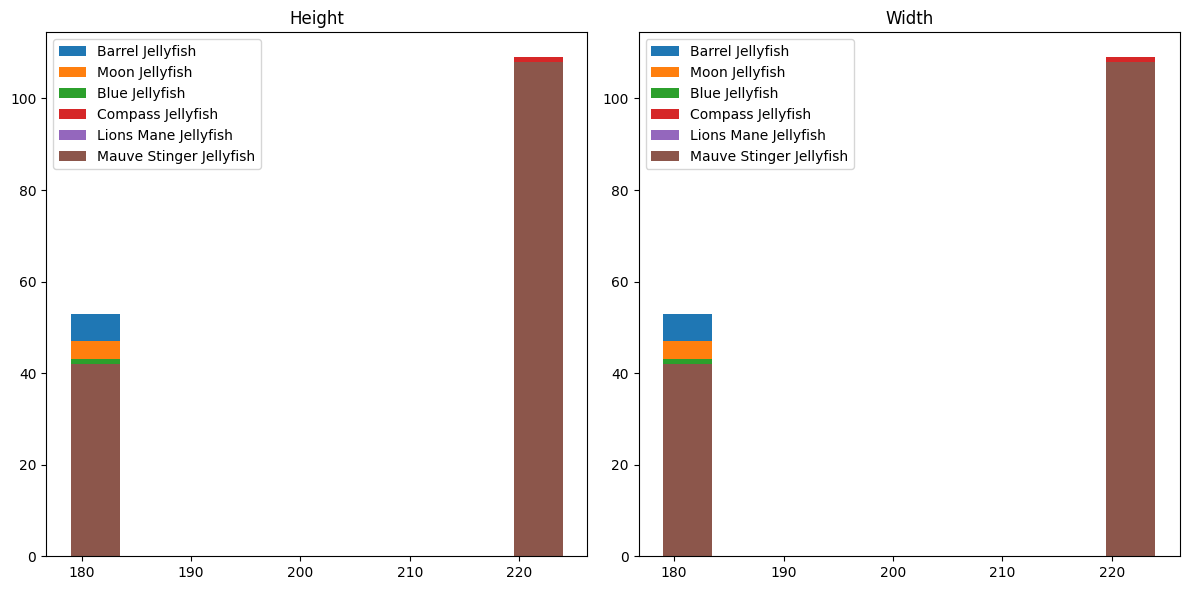

In [85]:
# Height and Width Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
x = [i for i in range(6)]

species = list(species_dimension.keys())

for sp in species:
    heights = species_dimension[sp]['height']
    heights.sort()
    widths = species_dimension[sp]['width']
    widths.sort()
    ax1.hist(heights, label=sp)
    ax2.hist(widths, label=sp)

ax1.set_title('Height')
# ax1.set_xticks()
ax1.legend()

ax2.set_title('Width')
# ax2.set_xticks([])
ax2.legend()

plt.tight_layout()
plt.show()

In [86]:
median_height = np.median([np.median(species_dimension[species]['height']) for species in species_dimension.keys()])
median_width = np.median([np.median(species_dimension[species]['width']) for species in species_dimension.keys()])
print(f'Median height: {median_height}\n',
      f'Median width: {median_width}')

Median height: 224.0
 Median width: 224.0


Since some of the images are not of the same size, the dimensions of the images will be resized into the same size (Median) for consistency.

## Pixel Values

In [87]:
image_path = os.path.join('/content', 'jellyfish', 'blue_jellyfish', '02.jpg')
image = Image.open(image_path)

# Convert the image to an array
image_array = np.array(image)
image_array

array([[[ 20,  75,  70],
        [ 20,  75,  70],
        [ 20,  75,  70],
        ...,
        [101, 198, 187],
        [101, 198, 187],
        [101, 198, 187]],

       [[ 20,  75,  70],
        [ 20,  75,  70],
        [ 20,  75,  70],
        ...,
        [101, 198, 187],
        [101, 198, 187],
        [101, 198, 187]],

       [[ 20,  75,  70],
        [ 20,  75,  70],
        [ 20,  75,  70],
        ...,
        [101, 198, 187],
        [101, 198, 187],
        [101, 198, 187]],

       ...,

       [[ 19,  38,  44],
        [ 19,  38,  44],
        [ 18,  37,  43],
        ...,
        [ 24,  80,  77],
        [ 27,  79,  77],
        [ 27,  79,  77]],

       [[ 21,  40,  46],
        [ 19,  38,  44],
        [ 17,  36,  42],
        ...,
        [ 22,  81,  79],
        [ 25,  79,  79],
        [ 25,  79,  79]],

       [[ 21,  40,  46],
        [ 19,  38,  44],
        [ 16,  35,  41],
        ...,
        [ 22,  81,  79],
        [ 24,  80,  79],
        [ 25,  79,  79]]

The pixel values aren't scaled yet, so it will be scaled in the pipeline.


## Colour Channel Consistency

In [88]:
species_colour_channel = {
    'Barrel Jellyfish': {'channel': set(species_dimension['Barrel Jellyfish']['channel'])},
    'Moon Jellyfish': {'channel': set(species_dimension['Moon Jellyfish']['channel'])},
    'Blue Jellyfish': {'channel': set(species_dimension['Blue Jellyfish']['channel'])},
    'Compass Jellyfish': {'channel': set(species_dimension['Compass Jellyfish']['channel'])},
    'Lions Mane Jellyfish': {'channel': set(species_dimension['Lions Mane Jellyfish']['channel'])},
    'Mauve Stinger Jellyfish': {'channel': set(species_dimension['Mauve Stinger Jellyfish']['channel'])}
}
species_colour_channel = pd.DataFrame(species_colour_channel)
species_colour_channel

,Barrel Jellyfish,Moon Jellyfish,Blue Jellyfish,Compass Jellyfish,Lions Mane Jellyfish,Mauve Stinger Jellyfish
channel,"{(R, G, B)}","{(R, G, B)}","{(R, G, B)}","{(R, G, B)}","{(R, G, B)}","{(R, G, B)}"


The colour channels from all the species are consistent where they only have 3 channels: **Red, Green and Blue**.

---

# v. Feature Engineering

## Data Preprocessing

In [89]:
!ls /content/jellyfish/Train_Test_Valid

test  Train  valid


In [90]:
IMG_HEIGHT, IMG_WIDTH = int(median_height), int(median_width)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale the pixel values from [0, 255] to [0, 1]
    horizontal_flip=True,       # Horizontal flipping
    vertical_flip=True,         # Vertical flipping
    rotation_range=180,          # Rotate image counter-clockwise and clockwise up to 180 degrees
    # brightness_range=[0.2,1.0], # Randomly darken or lighten images
    shear_range=0.1,            # Apply shearing transformation
    # width_shift_range=0.2,      # Shift images horizontally
    # height_shift_range=0.2,     # Shift images vertically
    zoom_range=0.2              # Zoom images
)
valid_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

# Train data
train_gen = train_datagen.flow_from_directory(
	'/content/jellyfish/Train_Test_Valid/Train/',
	target_size=(IMG_HEIGHT, IMG_WIDTH),
	class_mode='categorical',
    batch_size=BATCH_SIZE,
	shuffle=True
)
# Validation data
valid_gen = valid_datagen.flow_from_directory(
    '/content/jellyfish/Train_Test_Valid/valid',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)
# Test data
test_gen = test_datagen.flow_from_directory(
	'/content/jellyfish/Train_Test_Valid/test',
	target_size=(IMG_HEIGHT, IMG_WIDTH),
	class_mode='categorical',
    batch_size=BATCH_SIZE,
	shuffle=True
)

Found 900 images belonging to 6 classes.
Found 39 images belonging to 6 classes.
Found 40 images belonging to 6 classes.


A few examples of the augmented images.

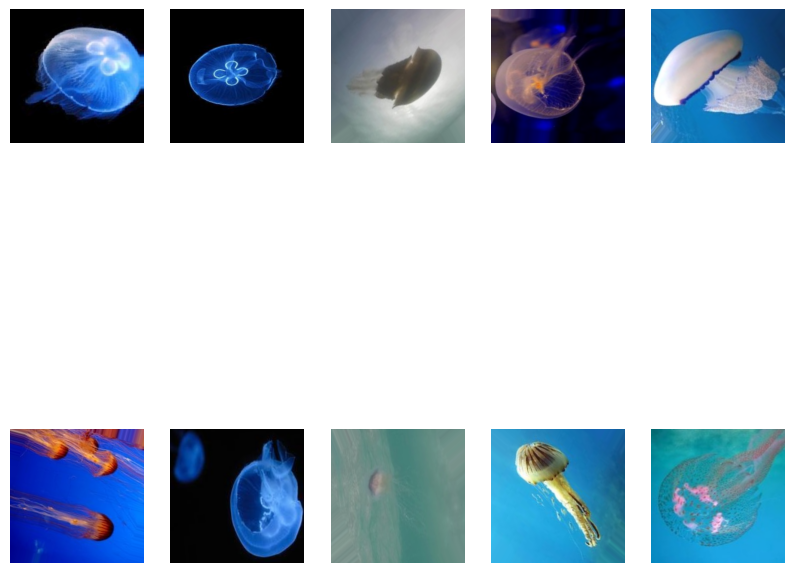

In [91]:
images, labels = next(train_gen)

num_images_to_show = 10

plt.figure(figsize=(10, 10))
for i in range(num_images_to_show):
    # Plot image
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    # plt.title(labels[i].argmax())
    plt.axis("off")

In [92]:
train_gen.next()[0].shape

(32, 224, 224, 3)

In [93]:
np.unique(train_gen.labels)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [94]:
np.unique(test_gen.labels)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [95]:
np.unique(valid_gen.labels)

array([0, 1, 2, 3, 4, 5], dtype=int32)

---

# vi. Model Definition

## Model Definitions

In [96]:
num_classes = 6  # Number of classes

The first model is relatively simple with a hidden layer, fully connected layer and a dropout layer compiled using the `Adam` optimizer with the default learning rate `0.001`.

In [97]:
# Model 1
tf.keras.backend.clear_session()

model_1 = Sequential([
    # Input Layer
    Conv2D(64, (3, 3), padding='valid', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),

    # Hidden Layer
    Conv2D(128, (3, 3), padding='valid', activation='relu'),
    MaxPooling2D(2, 2),

    # Fully connected layer
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),

    # Output layer for classification by probability
    Dense(num_classes, activation='softmax')
])

model_1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model layers
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 373248)            0         
                                                                 
 dense (Dense)               (None, 256)               9

The second model includes the pre-trained model `EfficientNetB0` compiled using the `Adam` optimizer with the default learning rate `0.001`.

In [98]:
efficient_net_b0 = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    classifier_activation='relu',
)

16705208/16705208 [==============================] - 0s 0us/step


In [99]:
# Model 2
tf.keras.backend.clear_session()

model_2 = Sequential([
    efficient_net_b0, # pre-trained model
    Flatten(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.1))
])

model_2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dropout (Dropout)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 6)                 376326    
                                                                 
Total params: 4425897 (16.88 MB)
Trainable params: 4383874 (16.72 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


The third model is an upgrade from the first model with a hidden layer, a fully connected layer and dropout compiled using the `Adam` optimizer with the default learning rate `0.001`.

In [100]:
# Model 3
tf.keras.backend.clear_session()

model_3 = Sequential([
    # Input Layer
    Conv2D(64, (2, 2), padding='valid', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),

    # Hidden Layer
    Conv2D(128, (2, 2), padding='valid', activation='relu'),
    MaxPooling2D(2, 2),

    # Fully connected layer
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.1)),
    Dropout(0.4),

    # Output layer for classification by probability
    Dense(num_classes, activation='softmax')
])

model_3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model layers
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 128)     32896     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 387200)            0         
                                                                 
 dense (Dense)               (None, 256)               9

The fourth model is an alternative to the first model with the `LeakyReLU` activation function instead of `ReLU` activation function compiled using the `Nadam` optimizer and a learning rate of `0.01`.

In [101]:
# Model 4
tf.keras.backend.clear_session()

model_4 = Sequential([
    # Input Layer
    Conv2D(16, (2, 2), padding='valid', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    LeakyReLU(alpha=0.2),
    MaxPooling2D(2, 2),

    # Fully connected layer
    Flatten(),
    Dense(32),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    # Output layer for classification by probability
    Dense(num_classes, activation='softmax')
])

# Nadam optimizer
model_4.compile(optimizer=Nadam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model layers
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 16)      208       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 223, 223, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 197136)            0         
                                                                 
 dense (Dense)               (None, 32)                6308384   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32)                0         
                                                        

## Callbacks

Callbacks are used to keep track of the best model, the methods:
- `ModelCheckpoint` to save the best model with the lowest `val_loss`
- `EarlyStopping` to stop the training as soon as there are no improvements on the `val_loss` for 7 epochs
- `ReduceLROnPlateau` to reduce the learning rate every time the `val_loss` stagnates for 2 epochs

In [102]:
# Model checkpoints for multiple models
checkpoint_1 = ModelCheckpoint(
    '/content/model_1/',
    monitor='val_loss',         # Monitor the validation loss
    save_best_only=True,        # Saving only the best model
    mode='min',                 # Most minimum val_loss is saved
    verbose=1
)
checkpoint_2 = ModelCheckpoint(
    '/content/model_2/',
    monitor='val_loss',         # Monitor the validation loss
    save_best_only=True,        # Saving only the best model
    mode='min',                 # Most minimum val_loss is saved
    verbose=1
)
checkpoint_3 = ModelCheckpoint(
    '/content/model_3/',
    monitor='val_loss',         # Monitor the validation loss
    save_best_only=True,        # Saving only the best model
    mode='min',                 # Most minimum val_loss is saved
    verbose=1
)
checkpoint_4 = ModelCheckpoint(
    '/content/model_4/',
    monitor='val_loss',         # Monitor the validation loss
    save_best_only=True,        # Saving only the best model
    mode='min',                 # Most minimum val_loss is saved
    verbose=1
)

In [103]:
# EarlyStopping to stop training when the validation loss has not improved for 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,                # Number of epochs with no improvement
    mode='min',                 # The training will stop when the quantity monitored has stopped decreasing
    verbose=1
)
# ReduceLROnPlateau to reduce the learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,                 # Factor by which the learning rate will be reduced
    patience=4,                 # Learning rate will be reduced after the val_loss plateaus for 4 epochs
    min_lr=1e-6,                # Lower bound on the learning rate
    mode='min',                 # The learning rate will be reduced when the quantity monitored has stopped decreasing
    verbose=1
)
callback_1 = [checkpoint_1, early_stopping, reduce_lr]
callback_2 = [checkpoint_2, early_stopping, reduce_lr]
callback_3 = [checkpoint_3, early_stopping, reduce_lr]
callback_4 = [checkpoint_4, early_stopping, reduce_lr]

---

# vii. Model Training

In [104]:
steps_per_epoch = np.ceil(train_gen.samples / BATCH_SIZE)
validation_steps = np.ceil(valid_gen.samples / BATCH_SIZE)

In [105]:
%%time
# Model 1
jellyfish_1 = model_1.fit(train_gen, epochs=25,
                        validation_data=valid_gen,
                        validation_steps=validation_steps,
                        steps_per_epoch=steps_per_epoch,
                        verbose=1, callbacks=callback_1)

Epoch 1/25
29/29 [==============================] - ETA: 0s - loss: 2.8623 - accuracy: 0.3044
Epoch 1: val_loss improved from inf to 1.26783, saving model to /content/model_1/
29/29 [==============================] - 261s 9s/step - loss: 2.8623 - accuracy: 0.3044 - val_loss: 1.2678 - val_accuracy: 0.6410 - lr: 0.0010
Epoch 2/25
29/29 [==============================] - ETA: 0s - loss: 1.3948 - accuracy: 0.4533
Epoch 2: val_loss improved from 1.26783 to 1.22143, saving model to /content/model_1/
29/29 [==============================] - 261s 9s/step - loss: 1.3948 - accuracy: 0.4533 - val_loss: 1.2214 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 3/25
29/29 [==============================] - ETA: 0s - loss: 1.3193 - accuracy: 0.4822
Epoch 3: val_loss did not improve from 1.22143
29/29 [==============================] - 249s 8s/step - loss: 1.3193 - accuracy: 0.4822 - val_loss: 1.2735 - val_accuracy: 0.4872 - lr: 0.0010
Epoch 4/25
29/29 [==============================] - ETA: 0s - loss: 1.2878

In [106]:
%%time
# Model 2
jellyfish_2 = model_2.fit(train_gen, epochs=25,
                        validation_data=valid_gen,
                        validation_steps=validation_steps,
                        steps_per_epoch=steps_per_epoch,
                        verbose=1, callbacks=callback_2)

Epoch 1/25
29/29 [==============================] - ETA: 0s - loss: 3.6350 - accuracy: 0.5311
Epoch 1: val_loss improved from inf to 6.60227, saving model to /content/model_2/
29/29 [==============================] - 360s 11s/step - loss: 3.6350 - accuracy: 0.5311 - val_loss: 6.6023 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 2/25
29/29 [==============================] - ETA: 0s - loss: 2.8832 - accuracy: 0.7789
Epoch 2: val_loss improved from 6.60227 to 6.04395, saving model to /content/model_2/
29/29 [==============================] - 326s 11s/step - loss: 2.8832 - accuracy: 0.7789 - val_loss: 6.0440 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 3/25
29/29 [==============================] - ETA: 0s - loss: 2.4424 - accuracy: 0.8533
Epoch 3: val_loss did not improve from 6.04395
29/29 [==============================] - 278s 10s/step - loss: 2.4424 - accuracy: 0.8533 - val_loss: 6.9752 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 4/25
29/29 [==============================] - ETA: 0s - loss: 2.2

KeyboardInterrupt: ignored

The second model appears to overfit extremely and the validation accuracy also plateaus, the training with this model is deemed unnecessary. So, there is no need to continue the training with the second (pre-trained) model.

In [107]:
%%time
# Model 3
jellyfish_3 = model_3.fit(train_gen, epochs=25,
                        validation_data=valid_gen,
                        validation_steps=validation_steps,
                        steps_per_epoch=steps_per_epoch,
                        verbose=1, callbacks=callback_3)

Epoch 1/25
29/29 [==============================] - ETA: 0s - loss: 17.5604 - accuracy: 0.2244
Epoch 1: val_loss improved from inf to 4.49691, saving model to /content/model_3/
29/29 [==============================] - 228s 8s/step - loss: 17.5604 - accuracy: 0.2244 - val_loss: 4.4969 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/25
29/29 [==============================] - ETA: 0s - loss: 2.9352 - accuracy: 0.2811
Epoch 2: val_loss improved from 4.49691 to 2.15992, saving model to /content/model_3/
29/29 [==============================] - 206s 7s/step - loss: 2.9352 - accuracy: 0.2811 - val_loss: 2.1599 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/25
29/29 [==============================] - ETA: 0s - loss: 2.2986 - accuracy: 0.2922
Epoch 3: val_loss improved from 2.15992 to 1.99476, saving model to /content/model_3/
29/29 [==============================] - 212s 7s/step - loss: 2.2986 - accuracy: 0.2922 - val_loss: 1.9948 - val_accuracy: 0.3590 - lr: 0.0010
Epoch 4/25
29/29 [===============

KeyboardInterrupt: ignored

The third model doesn't show any significant improvement over the few epochs it ran. So, it is interrupted mid-training for efficiency.

In [108]:
%%time
# Model 4
jellyfish_4 = model_4.fit(train_gen, epochs=25,
                                validation_data=valid_gen,
                                validation_steps=validation_steps,
                                steps_per_epoch=steps_per_epoch,
                                verbose=1, callbacks=callback_4)

Epoch 1/25
29/29 [==============================] - ETA: 0s - loss: 10.2239 - accuracy: 0.2422
Epoch 1: val_loss improved from inf to 1.83142, saving model to /content/model_4/
29/29 [==============================] - 40s 1s/step - loss: 10.2239 - accuracy: 0.2422 - val_loss: 1.8314 - val_accuracy: 0.3846 - lr: 0.0100
Epoch 2/25
29/29 [==============================] - ETA: 0s - loss: 2.2527 - accuracy: 0.3278
Epoch 2: val_loss did not improve from 1.83142
29/29 [==============================] - 35s 1s/step - loss: 2.2527 - accuracy: 0.3278 - val_loss: 1.8331 - val_accuracy: 0.3846 - lr: 0.0100
Epoch 3/25
29/29 [==============================] - ETA: 0s - loss: 1.8172 - accuracy: 0.3378
Epoch 3: val_loss improved from 1.83142 to 1.27838, saving model to /content/model_4/
29/29 [==============================] - 36s 1s/step - loss: 1.8172 - accuracy: 0.3378 - val_loss: 1.2784 - val_accuracy: 0.4359 - lr: 0.0100
Epoch 4/25
29/29 [==============================] - ETA: 0s - loss: 1.6323 

## Model Changes

| Model         | Model Description             | Final Epoch Accuracy | Final Epoch Validation Accuracy |
|---------------|-------------------------------|----------------------|---------------------------------|
| First Model   | 95m params                    | 0.78                 | 0.62                            |
| Second Model  | Pre-trained                   | INTERRUPTED                | INTERRUPTED                            |
| Third Model   | First model + regularizer     | INTERRUPTED                 | INTERRUPTED                            |
| Fourth Model  | Leaky ReLU with Nadam optimizer | 0.47          | 0.56                            |


With multiple models created,
- The **first model** is still the best model
- The second (pre-trained) model has a very high accuracy but its validation accuracy is extremely low indicating extreme overfitting
- The third model is the first model but with a regularizer added
- The fourth model is a simple model using Leaky ReLU as the activation function but still performs worse than the first model



---

# viii. Model Evaluation

In [124]:
def plot_history(training_result):
    training_result_df = pd.DataFrame(training_result.history)
    plt.figure(figsize=(15, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    sns.lineplot(data=training_result_df[['accuracy', 'val_accuracy']])
    plt.grid()
    plt.xticks([x for x in range(0, 25, 2)])
    plt.title('Accuracy vs Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    sns.lineplot(data=training_result_df[['loss', 'val_loss']])
    plt.grid()
    plt.xticks([x for x in range(0, 25, 1)])
    plt.title('Loss vs Validation Loss')

    plt.show()

In [110]:
def confusion_matrix_plot(model, data):
    pred = model.predict(data, steps=len(data))
    pred_class = np.argmax(pred, axis=1)
    true_class = data.classes
    class_labels = list(data.class_indices.keys())

    # Classification Report
    # print(classification_report(true_class, pred_class, target_names=class_labels))

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_class, pred_class)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## First Model

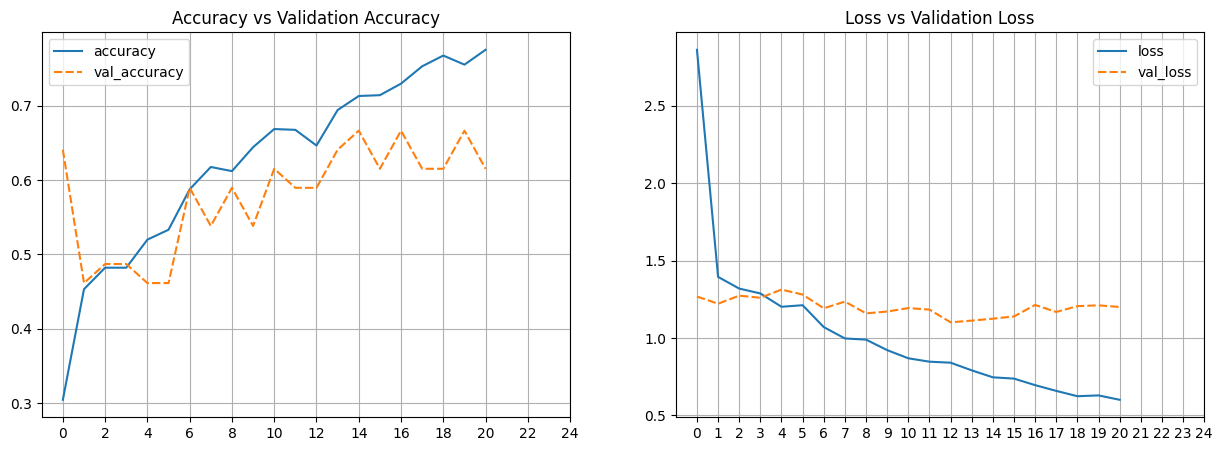

In [125]:
plot_history(jellyfish_1)

29/29 [==============================] - 72s 2s/step


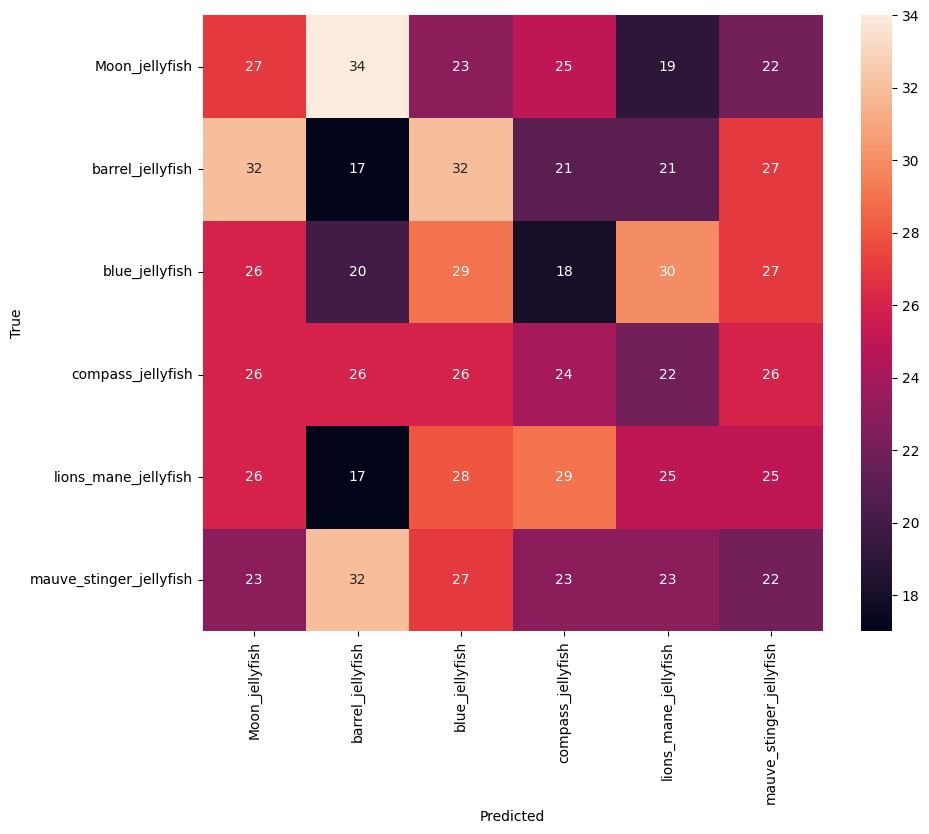

In [112]:
confusion_matrix_plot(model_1, train_gen)

2/2 [==============================] - 4s 646ms/step


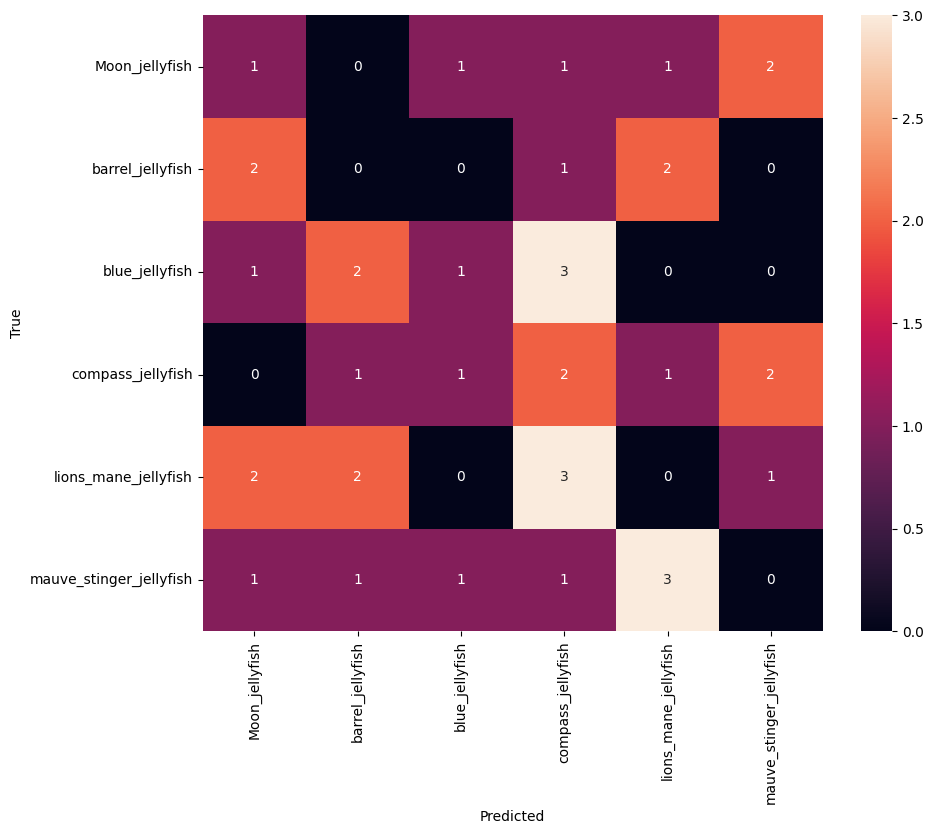

In [113]:
confusion_matrix_plot(model_1, test_gen)

In [114]:
test_steps = np.ceil(test_gen.samples / BATCH_SIZE)
test_loss_1, test_acc_1 = model_1.evaluate(test_gen, steps=test_steps)
print(f'Test loss: {test_loss_1}\n',
      f'Test accuracy: {test_acc_1}')

2/2 [==============================] - 2s 440ms/step - loss: 0.9645 - accuracy: 0.6750
Test loss: 0.9645123481750488
 Test accuracy: 0.675000011920929


The first model is evaluated by predicting the test data and it's shown to have an accuracy of 0.65. Furthermore, it appears to not overfit but the score is fairly moderate. The other models don't perform as well as the first model. However, the first model's file size exceeds 1 GB. So, the fourth model will be used for inference instead.

## Fourth Model

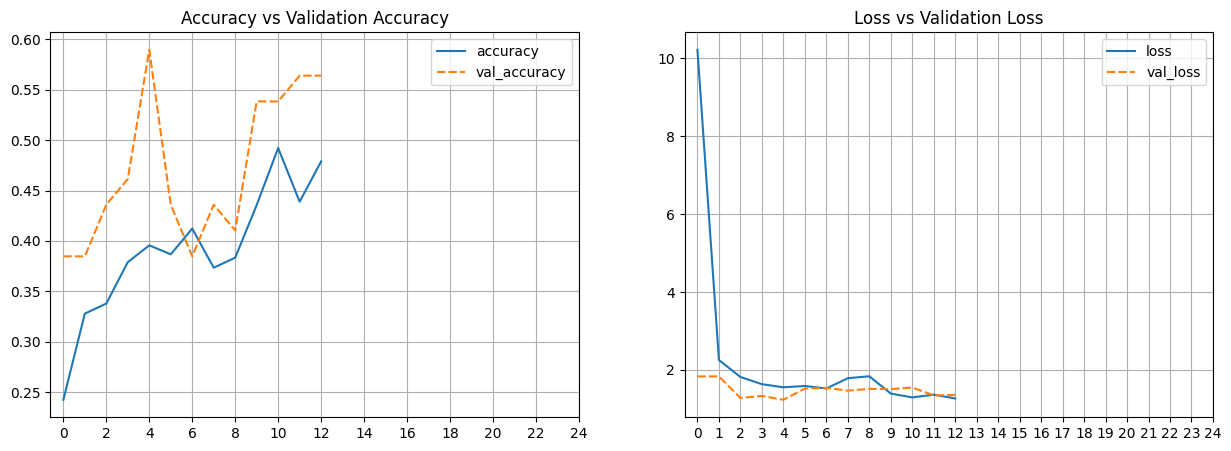

In [126]:
plot_history(jellyfish_4)

29/29 [==============================] - 24s 804ms/step


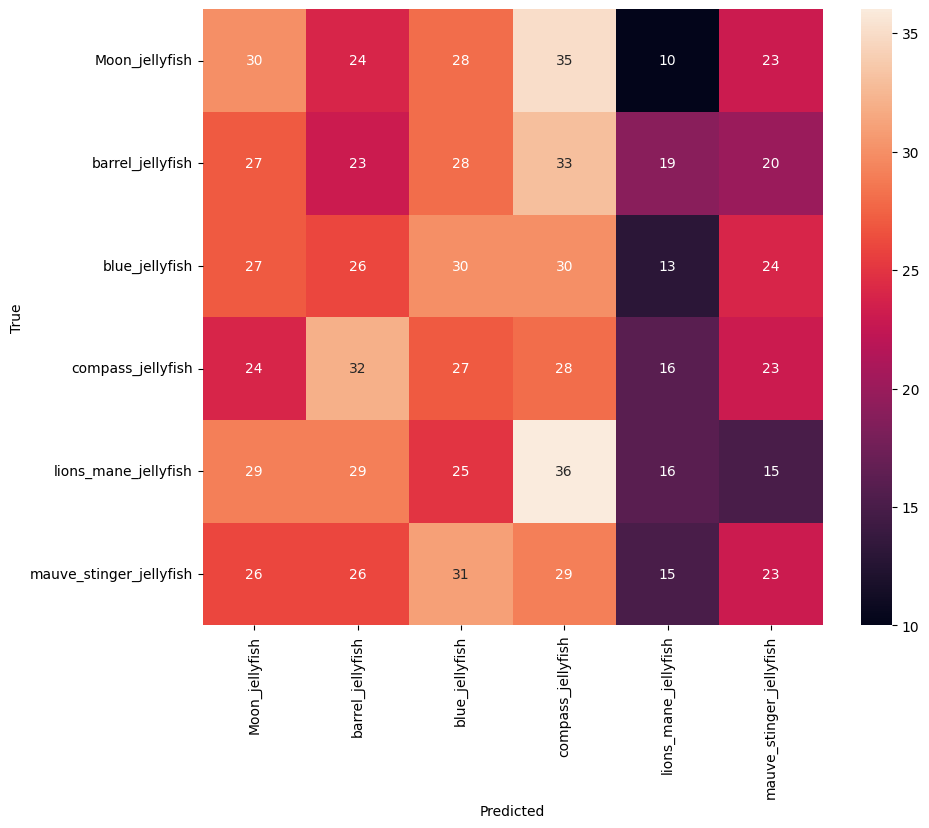

In [117]:
confusion_matrix_plot(model_4, train_gen)

2/2 [==============================] - 0s 61ms/step


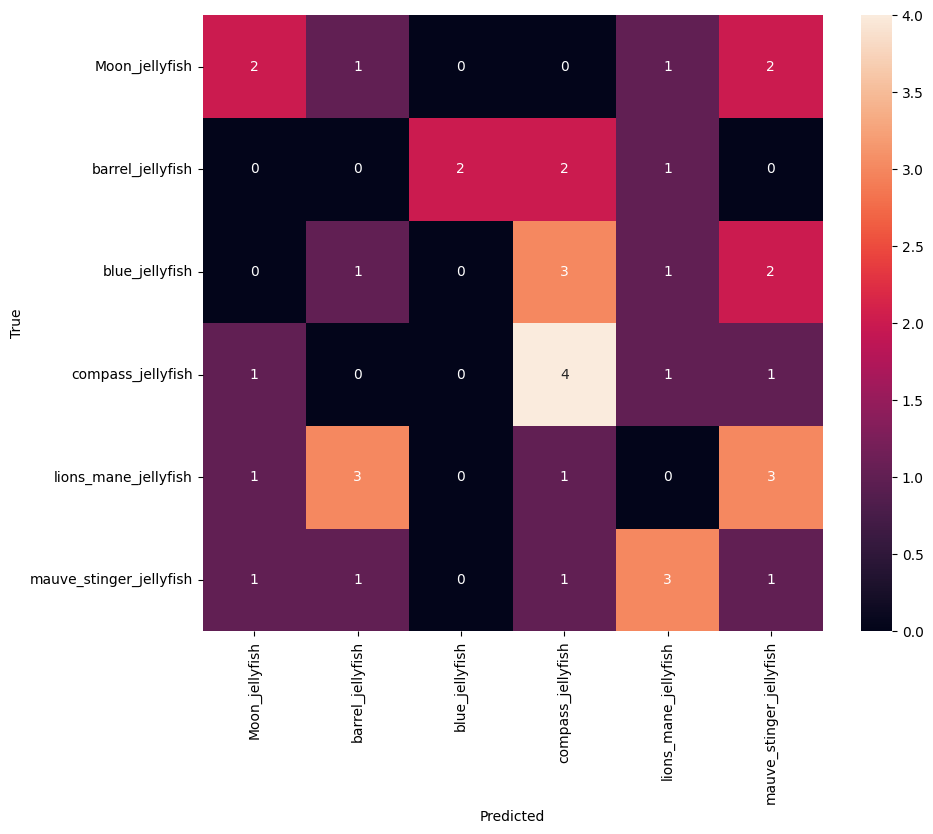

In [118]:
confusion_matrix_plot(model_4, test_gen)

In [119]:
test_loss_4, test_acc_4 = model_4.evaluate(test_gen, steps=test_steps)
print(f'Test loss: {test_loss_4}\n',
      f'Test accuracy: {test_acc_4}')

2/2 [==============================] - 0s 65ms/step - loss: 1.3117 - accuracy: 0.5750
Test loss: 1.311661958694458
 Test accuracy: 0.574999988079071


The fourth model is evaluated by predicting the test data and it's shown to have an accuracy of 0.58. However, the fourth model still doesn't perform as well as the first model. But with limitations in mind, the fourth model will be used for inference.

In [121]:
# !zip -r /content/model_4.zip /content/model_4

  adding: content/model_4/ (stored 0%)
  adding: content/model_4/variables/ (stored 0%)
  adding: content/model_4/variables/variables.index (deflated 60%)
  adding: content/model_4/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/model_4/fingerprint.pb (stored 0%)
  adding: content/model_4/keras_metadata.pb (deflated 88%)
  adding: content/model_4/assets/ (stored 0%)
  adding: content/model_4/saved_model.pb (deflated 87%)


---

# ix. Model Saving

Since `ModelCheckpoint` was used on each model, there is no need to save the model here. Instead, the model chosen will be saved locally for the model deployment.

---

# x. Model Inference

Model Inference is done on a separate notebook.

---

# xi. Conclusion

With the main goal of predicting jellyfish species using images obtained from Kaggle, a few models were created and trained to classify the jellyfishes. The result were four models, two which were interrupted mid-training because they did not have any major improvements compared to the other models. The two models that did finish training showed different results, the first model was the most promising model with a training accuracy of 0.78 and validation accuracy of 0.62. However, the first model was not used for inference because the file size is too large to save and deploy. The fourth model with a training accuracy of 0.47 and validation accuracy of 0.56 was instead saved and deployed as an alternative.